In [47]:
# setup modules
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import numpy as np
import warnings
import ee
import geemap
import elevation
import geopandas
import sys,os,os.path

warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

data_dir=os.path.expanduser('~/scratch/beam_block')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# create geo subdir
if not os.path.exists(data_dir+'/geo'):
    os.makedirs(data_dir+'/geo')
    
    
os.environ['WRADLIB_DATA']=os.path.expanduser(data_dir)
print(os.environ['WRADLIB_DATA'])

ee.Initialize()

/Users/sserbin/scratch/beam_block


In [48]:
#sitecoords = (34.655312, -87.340714, 175)
#Courtland,AL airport
sitecoords = (-87.3401, 34.6554, 179)
nrays = 360 # number of rays
nbins = 1000 # number of range bins
el = 1.0 # vertical antenna pointing angle (deg)
bw = 1.0 # half power beam width (deg)
range_res = 100. # range resolution (meters)

In [49]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [50]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      coord[..., 1],
                                      coord[..., 2], sitecoords)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [51]:
polcoords = coords[..., :2]
print("lon,lat,alt:", coords.shape)

lon,lat,alt: (360, 1000, 3)


In [52]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (lat.max(), lon.min(), lon.max(), lat.min()))

Radar bounding box:
	35.56
-88.43             -86.25
	33.75


In [53]:
#-94.614744, 29.317645, -74.441221, 36.520919
#
# -88.563628, 33.618876, -85.843867, 34.993936  -- smaller region around BNF
dem_path = os.path.expanduser(data_dir+'/geo/'+'amf3_dem.tif')
print(dem_path)
#elevation.clip(bounds=(12.35, 41.8, 12.65, 42), output='Rome-DEM.tif')
elevation.clip(bounds=(-89.0, 33.0, -85.0, 35.0), output=dem_path, product='SRTM3')
elevation.clean()

/Users/sserbin/scratch/beam_block/geo/amf3_dem.tif
make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM3.vrt SRTM3.c8e9867047044029aa928bd8ca1cbe62.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -89.0 35.0 -85.0 33.0 SRTM3.c8e9867047044029aa928bd8ca1cbe62.vrt /Users/sserbin/scratch/beam_block/geo/amf3_dem.tif
rm -f SRTM3.c8e9867047044029aa928bd8ca1cbe62.vrt
find cache -size 0 -name "*.tif" -delete
rm -f SRTM1.*.vrt
rm -f -r spool/*


In [54]:
rasterfile = wrl.util.get_wradlib_data_file(os.path.expanduser(data_dir+'/geo/'+'amf3_dem.tif'))
#print(rasterfile)
ds = wrl.io.open_raster(rasterfile)
#print(ds)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)
#print(rastercoords)
#print(rastervalues)
#print(proj)

# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]
#print(ind)
#print(rastercoords)

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

(683, 1494, 3300, 2400)
[[[-88.43041667  33.75458333]
  [-88.42958333  33.75458333]
  [-88.42875     33.75458333]
  ...
  [-86.25208333  33.75458333]
  [-86.25125     33.75458333]
  [-86.25041667  33.75458333]]

 [[-88.43041667  33.75375   ]
  [-88.42958333  33.75375   ]
  [-88.42875     33.75375   ]
  ...
  [-86.25208333  33.75375   ]
  [-86.25125     33.75375   ]
  [-86.25041667  33.75375   ]]

 [[-88.43041667  33.75291667]
  [-88.42958333  33.75291667]
  [-88.42875     33.75291667]
  ...
  [-86.25208333  33.75291667]
  [-86.25125     33.75291667]
  [-86.25041667  33.75291667]]

 ...

 [[-88.43041667  33.00208333]
  [-88.42958333  33.00208333]
  [-88.42875     33.00208333]
  ...
  [-86.25208333  33.00208333]
  [-86.25125     33.00208333]
  [-86.25041667  33.00208333]]

 [[-88.43041667  33.00125   ]
  [-88.42958333  33.00125   ]
  [-88.42875     33.00125   ]
  ...
  [-86.25208333  33.00125   ]
  [-86.25125     33.00125   ]
  [-86.25041667  33.00125   ]]

 [[-88.43041667  33.00041667]


In [55]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360, 1000)


In [56]:
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 1000)


In [57]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        pl.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

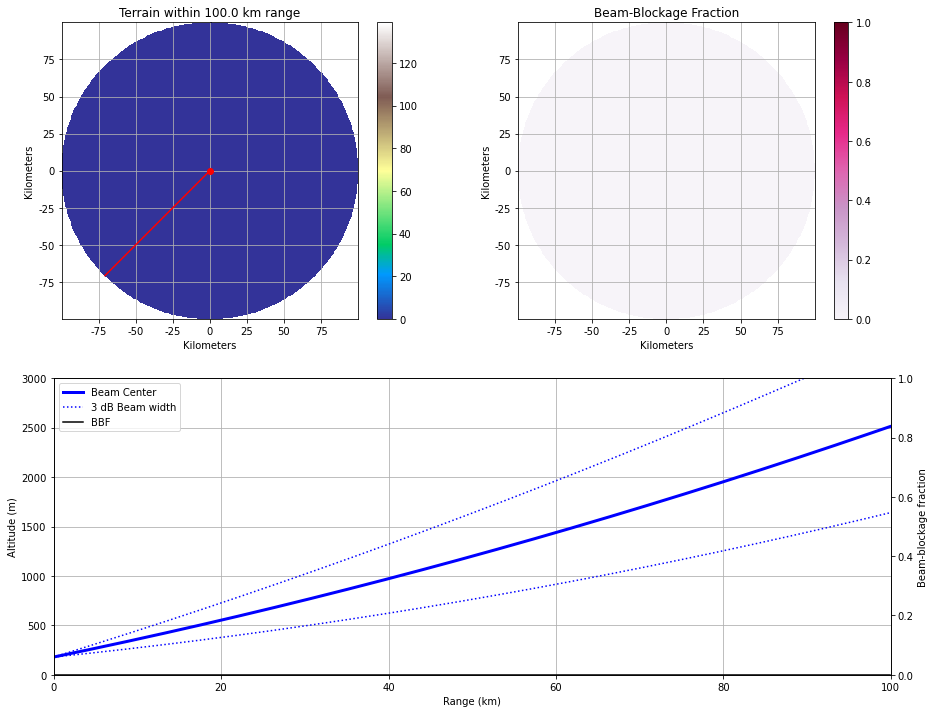

In [58]:
fig = pl.figure(figsize=(15, 12))

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 225

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues,
                            ax=ax1, r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(sitecoords[0], sitecoords[1], 'ro')
annotate_map(ax1, dem, 'Terrain within {0} km range'.format(np.max(r / 1000.) + 0.1))

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, 'Beam-Blockage Fraction')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)